In [3]:
# Import stuff
'''
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sbi import utils as utils
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi import inference as Inference
import pickle
import timeit
'''
#!pip install sbi
import torch
import numpy as np
import matplotlib.pyplot as plt
from sbi import utils as utils
from sbi import inference as Inference


# Note that we are lazily using the CPU, but this is faster w/ a GPU
if torch.cuda.is_available(): device = 'mps'
else: device = 'cpu'
print(f'device is {device}')

device is cpu


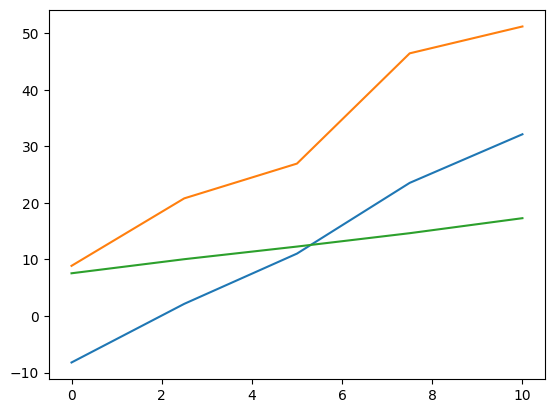

In [4]:
def make_data(N=1000, test_fraction = 0.2, plot=True):
  '''
  Going to make some noisy lines
  They will all have 5 points, evenly spaced between 0 and 10
  The free parameters are the slope and y-intercept:
  y = m * times + b
  '''
  times = np.linspace(0,10,5)
  m_set = np.random.uniform(0,5,N)
  b_set = np.random.uniform(-10,10,N)

  y = (np.outer(times, m_set) + b_set).T
  y += y * np.random.normal(loc=0, scale = 0.2, size=(N, 5))
  X = np.vstack((m_set, b_set)).T

  # We're also going to go ahead and split this training/test set
  test_number = int(test_fraction * N)
  X_train = X[test_number:]
  y_train = y[test_number:]
  X_test = X[0:test_number]
  y_test = y[0:test_number]

  if plot:
    plt.plot(times,y_train[0])
    plt.plot(times,y_train[2])
    plt.plot(times,y_train[3])


  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = make_data()


In [6]:
# Let's train!

# Make our 'implicit prior'. In other words, tell the flow
# How are the simulations distributed over the parameters?
# In this case, I'm assuming it's flat
# Note, this is a 2D prior -- the min and listed first, then the max

# Set some parameters of our flow..
nhidden = 20
nblocks = 5


prior_low   = [0,-10]
prior_high  = [5, 10]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_low), high=torch.as_tensor(prior_high)
)

# This sets up the flow
anpe = Inference.SNPE(
        prior=prior,
        density_estimator=utils.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
        device=device)
anpe.append_simulations(
    torch.as_tensor(X_train.astype(np.float32)),
    torch.as_tensor(y_train.astype(np.float32)))
p_x_y_estimator = anpe.train(stop_after_epochs=100) # Set this to a higher number to run for longer
hatp_x_y = anpe.build_posterior(p_x_y_estimator)

 Neural network successfully converged after 392 epochs.

Drawing 100 posterior samples: 198it [00:00, 17678.65it/s]            
Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 9242.02it/s]


Drawing 100 posterior samples: 193it [00:00, 12286.57it/s]            
Drawing 100 posterior samples: 143it [00:00, 11098.10it/s]            
Drawing 100 posterior samples: 135it [00:00, 11617.86it/s]            
Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 10782.83it/s]
Drawing 100 posterior samples: 198it [00:00, 17365.54it/s]            
Drawing 100 posterior samples: 174it [00:00, 15667.19it/s]            
Drawing 100 posterior samples: 100%|██████████| 100/100 [00:00<00:00, 17313.95it/s]
Drawing 100 posterior samples: 199it [00:00, 21520.34it/s]            


Text(0, 0.5, 'Predicted Slope')

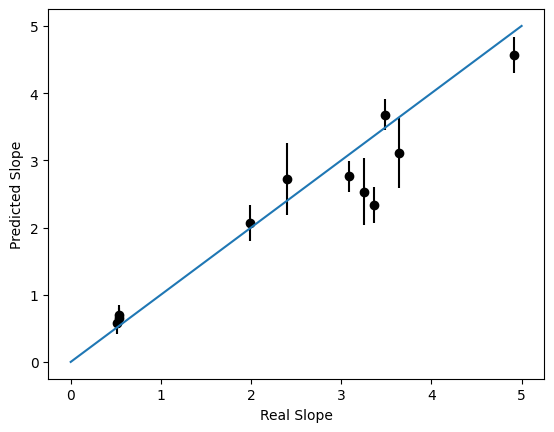

In [7]:
for i,specific_y_test in enumerate(y_test):
    if i>10:
        continue
    samples = hatp_x_y.sample((100,),x=specific_y_test).numpy()
    plt.plot(X_test[i][0],np.median(samples[:,0]),'ko')
    plt.errorbar(X_test[i][0],np.median(samples[:,0]),yerr=(np.percentile(samples[:,0],84)-np.percentile(samples[:,0],16))/2.0, color='black')
plt.plot([0,5], [0,5])
plt.xlabel('Real Slope')
plt.ylabel('Predicted Slope')